## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings


## Data preparation

In [2]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [3]:
clean_df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
38801,Y2-ekrLskUY,MyStudy,Top Python IDE ( Integrated Development Enviro...,Python\r\n CMD Terminal\r\n IDLE\r\n Editors\r...,Python|Programming|Language|IDE|Integrated Dev...,2020-09-25 11:59:54+00:00,1711,30,5,2060,hd,False,11,25,4,9,2020
43156,Mnxe-RA6gjQ,itversity,15 Scala Fundamentals - Compile changes and ru...,Connect with me or follow me at\r\nhttps://www...,(notag),2017-11-26 00:40:18+00:00,2251,5,1,262,hd,False,0,26,6,11,2017
51746,IK4eof_Ia-c,Analytics India Magazine,"AMANDEEP SINGH CHHABRA, Senior Data Scientist ...",Amandeep is currently working as a Senior Data...,AMANDEEP SINGH CHHABRA,2019-10-08 03:01:41+00:00,1224,15,0,424,hd,False,3,8,1,10,2019
30357,7FLJVSBPtvw,AI Planet,GenAI Stack: End to End LLM Framework,Module 14: LLM Bootcamp: Zero to Hero in LLMs\...,(notag),2023-09-25 01:21:01+00:00,762,17,2,4085,hd,False,1,25,0,9,2023
11526,vFfH3jVCCs0,Analytics Vidhya,The DataHour: Designing an end-to-end Neural S...,The DataHour: Designing an end-to-end Neural S...,machine learning|deep learning|artificial inte...,2022-08-19 03:20:59+00:00,434,16,1,7293,hd,False,3,19,4,8,2022


## Feature engineering

Create a `isTrending` column based on our criteria for the viewCount values, where labels 'low', 'medium', 'high' are assigned based on the mean value.


Noted: We assume that low: 0, medium: 1, high: 2

In [4]:
X = clean_df[['likeCount', 'commentCount', 'hour', 'day', 'month', 'year']]
mean_engagement = clean_df['viewCount'].mean()
# assign labels based on the engagement
clean_df['isTrending'] = pd.cut(clean_df['viewCount'], 
                               bins=[float('-inf'), mean_engagement, mean_engagement *10, float('inf')], 
                               labels=False)
y = clean_df['isTrending']

In [5]:
clean_df.sample(5)


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year,isTrending
24716,XVhjNeenJf0,BEPEC by Kanth - #BuildExperience & Get Hired!,3 Primary Cloud Deployment Models || Cloud Dep...,Comment/contact us to build experience on Data...,3 Primary Cloud Deployment Models|top cloud de...,2022-12-28 06:55:05+00:00,1462,50,0,61,hd,False,6,28,2,12,2022,0
40653,9TyKMEoUMy0,How to Power BI,This ONE IDEA opens ENDLESS POSSIBILITIES | Co...,In this video I show you how to create a refer...,constant lines power bi|constant lines in powe...,2021-08-22 10:30:30+00:00,27089,1050,59,538,hd,False,10,22,6,8,2021,0
54351,CRBVwmnL2Jk,TechLake,Databricks Tutorial 15: Databricks workspace l...,#Databricks\r\n#Pyspark\r\n#Spark\r\n#AzureDat...,(notag),2020-09-01 17:47:36+00:00,3105,31,5,469,hd,False,17,1,1,9,2020,0
6828,Wibxjrxf5ko,codebasics,Matrix Basics | Deep Learning Tutorial 10 (Ten...,Matrix fundamentals are essential to understan...,matrix explained|matrix deep learning|matrix i...,2020-08-04 14:00:10+00:00,85836,2187,62,702,hd,False,14,4,1,8,2020,1
37999,UjRcLkIuxjk,Data Science Tutorials,Python Matplotlib Tutorial | Customize Matplot...,Hi guys...in this video I have talked about ho...,how to add labels in matplotlib chart|how to a...,2018-05-08 03:42:25+00:00,443,4,0,622,hd,False,3,8,1,5,2018,0


In [6]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y ,test_size=0.3, random_state= 2023,stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp ,test_size=0.5, random_state= 2023,stratify=y_tmp)

# Baseline Model Comparison


In [7]:
from sklearn.svm import LinearSVC , SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

seed = 2023
models = [
    LinearSVC(random_state=seed, dual=False, max_iter=1000),
    SVC(random_state=seed),
    RandomForestClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed)
]

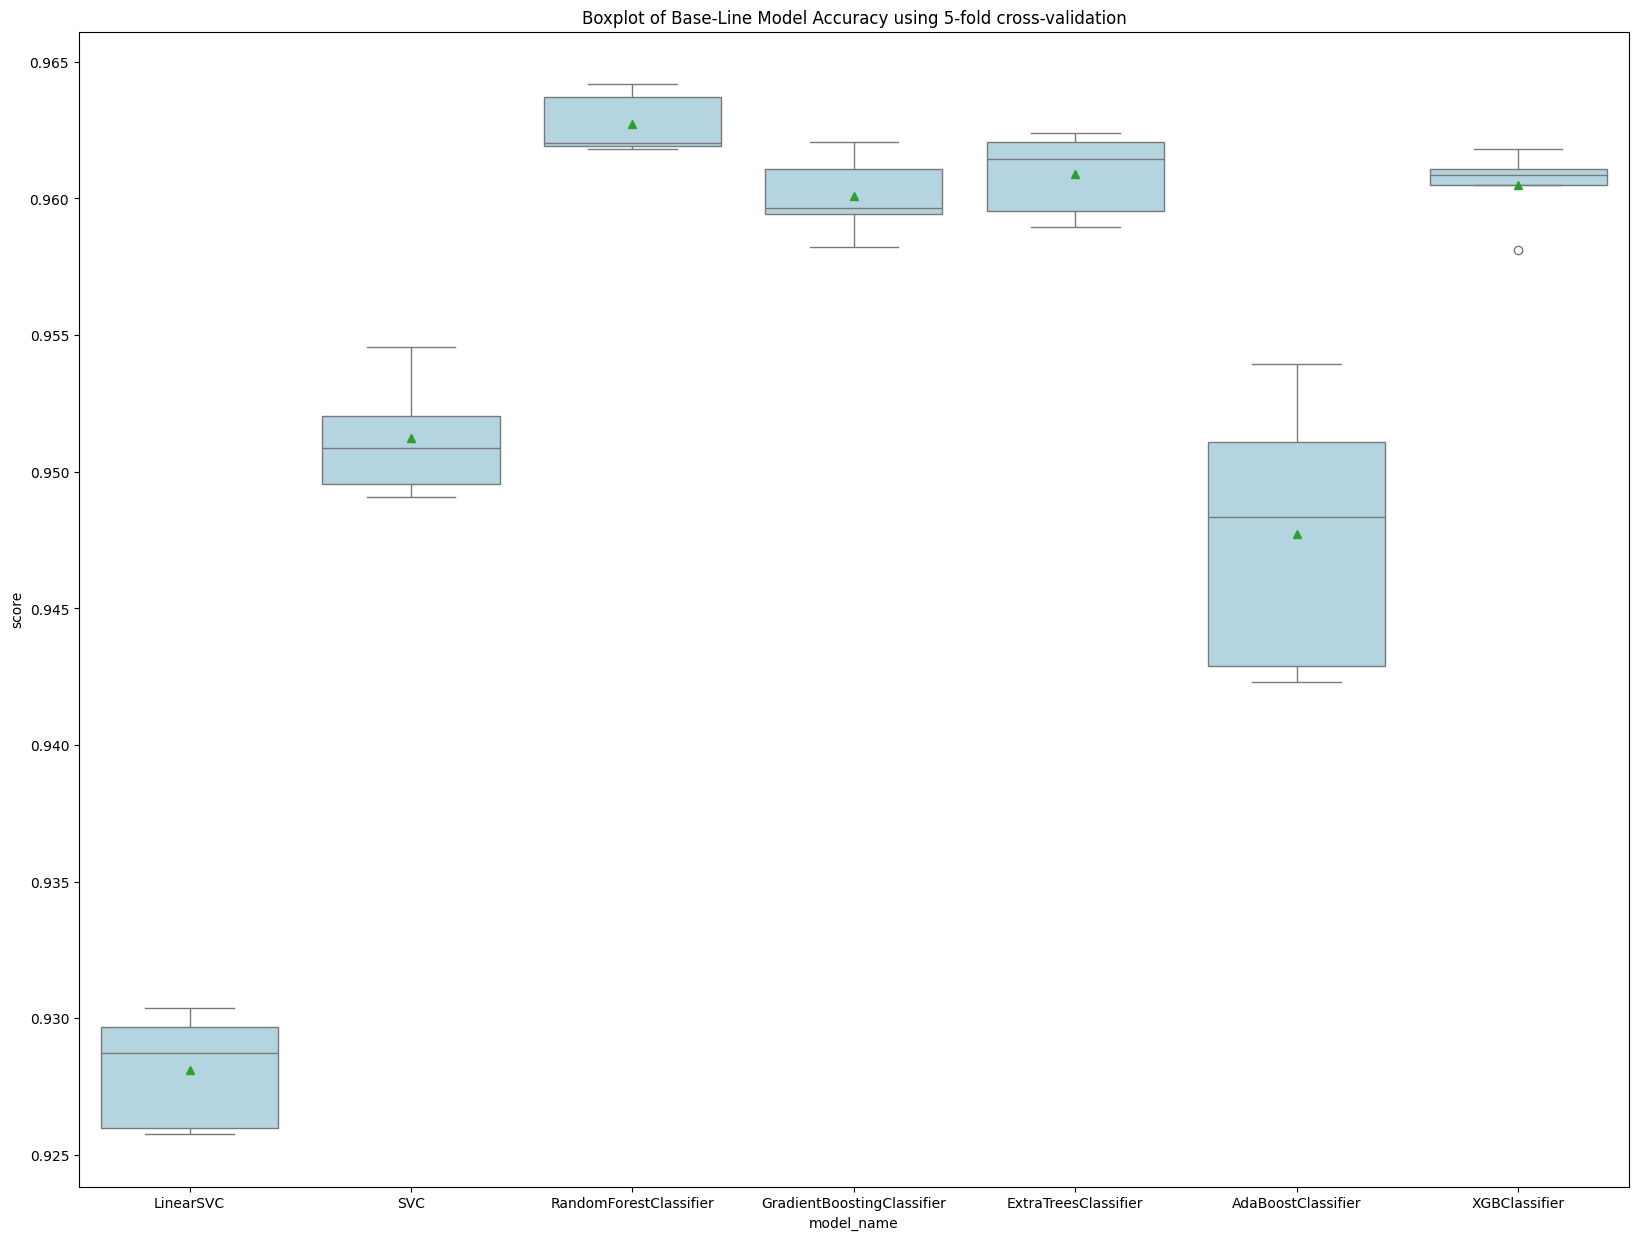

,Mean,Standard Deviation
model_name,,
RandomForestClassifier,0.962734,0.001124
ExtraTreesClassifier,0.960878,0.001540
XGBClassifier,0.960473,0.001402
GradientBoostingClassifier,0.960092,0.001491
SVC,0.951216,0.002198
AdaBoostClassifier,0.947718,0.005087
LinearSVC,0.928109,0.002127


In [8]:
def generate_baseline_result(models, X, y, metrics, cv=5, plot_result=False):
    # define k-fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])
    
    mean = cv_df.groupby('model_name')['score'].mean()
    std = cv_df.groupby('model_name')['score'].std()
    
    baseline_results = pd.concat([mean,std],axis =1, ignore_index=True)
    baseline_results.columns =['Mean','Standard Deviation']
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace = True)
    
    if plot_result:
        plt.figure(figsize=(20, 15))
        sns.boxplot(x ='model_name',y = 'score', data = cv_df, color ='lightblue',showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validation')
        plt.show()
    
    return baseline_results

generate_baseline_result(models, X_train, y_train, metrics='accuracy',cv=5,plot_result =True )

# Train model

In [9]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred_best = model.predict(X_test)

# Evaluate the best model
print(f"Model Accuracy: {accuracy_score(y_test, y_pred_best)}")

Model Accuracy: 0.9654636313159356


# Fine-tune 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=2023),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_valid, y_valid)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

best_params

# Re-train on train + valid set

In [ ]:
final_model_train_valid = RandomForestClassifier(random_state=2023, **best_params)

X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)
final_model_train_valid.fit(X_train_valid, y_train_valid)

# Test on test set 

In [ ]:
y_pred_final_train_valid = final_model_train_valid.predict(X_test)
accuracy_final_train_valid = accuracy_score(y_test, y_pred_final_train_valid)
print(f"Accuracy of the Final Model on Test Set: {accuracy_final_train_valid}")

# Visualize

In [ ]:
cm = confusion_matrix(y_test, y_pred_final_train_valid)

# Biểu đồ heatmap cho confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(accuracy_score)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color="g"
    )

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Định nghĩa mô hình và các thông số cần thiết
model = RandomForestClassifier(random_state=2023, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

# Vẽ đường học tập
plot_learning_curve(model, "Learning Curve", X_train_valid, y_train_valid, cv=cv, n_jobs=-1)
plt.show()